# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve as conv
from scipy.signal import correlate as corr

# Convolution and Correlation

We'll start by creating a simple signal (image) and a simple filter. We'll then convolve the two using:

1. `scipy.signal.correlate` (The convolution in CNNs is actually a correlation)
2. `scipy.signal.convolve` (This is the same as `correlate` but with the filter flipped. Original definition of convolution)
3. Custom convolution function

Then we'll compare the results of the three methods. We'll also have a look at which method is faster. (This is obviously be the `scipy` methods)

## Creating the Image and Filter

Let's start with creating some "images".

array([[ 46,   2, 227, 161,   9],
       [ 99, 187,   1, 214, 179],
       [225,  27, 165, 101,  60],
       [195,  43, 252,  66,  30],
       [ 64,  12, 198,  10,  80]])

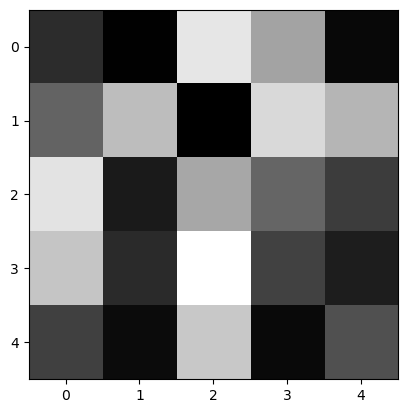

In [2]:
img = np.random.randint(0, 255, (5, 5, 1))
img2d = img[:, :, 0]
display(img2d)
plt.imshow(img, cmap='gray')

We'll also create a kernel.

array([[ 35,   5,  16],
       [ 59, 211, 176],
       [114,  72,  62]])

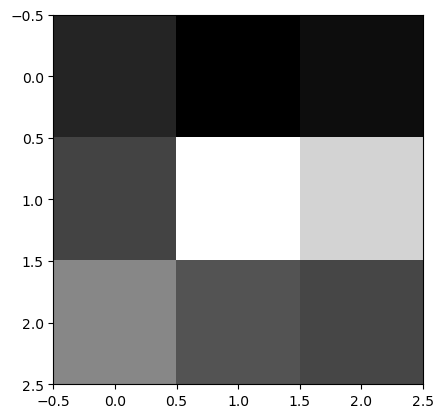

In [3]:
k = np.random.randint(0, 255, (3, 3, 1))
k2d = k[:, :, 0]
display(k2d)
plt.imshow(k, cmap='gray')

So, we have a $5 \times 5$ image and a $3 \times 3$ kernel. The convolutions, which we'll use are `same`, `valid` and `full`. The output shape for these three modes are:

1. `same`: $5 \times 5$
2. `valid`: $3 \times 3$
3. `full`: $7 \times 7$


# Comparing Results

## The `convolution` function

As we discussed, the *convolution* in CNNs is actually a correlation. For completeness, we'll also use the `convolution` function. This is the same as `correlate` but with the filter flipped and it will help us compare the results of the two methods.

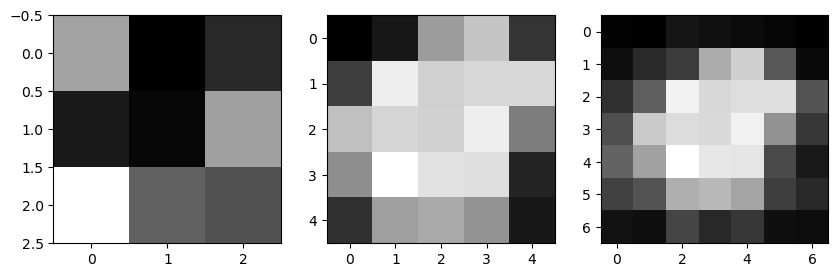

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

valid_conv = conv(img, k, mode='valid')
ax[0].imshow(valid_conv, cmap='gray')

same_conv = conv(img, k, mode='same')
ax[1].imshow(same_conv, cmap='gray')

full_conv = conv(img, k, mode='full')
ax[2].imshow(full_conv, cmap='gray')

In [5]:
assert valid_conv.shape == (3, 3, 1)
assert same_conv.shape == (5, 5, 1)
assert full_conv.shape == (7, 7, 1)

Great! We see that the shapes are correct.

In [6]:
k_flipped = np.flip(k, axis=(0, 1))
display(k_flipped[:, :, 0])
display(k2d)

array([[ 62,  72, 114],
       [176, 211,  59],
       [ 16,   5,  35]])

array([[ 35,   5,  16],
       [ 59, 211, 176],
       [114,  72,  62]])

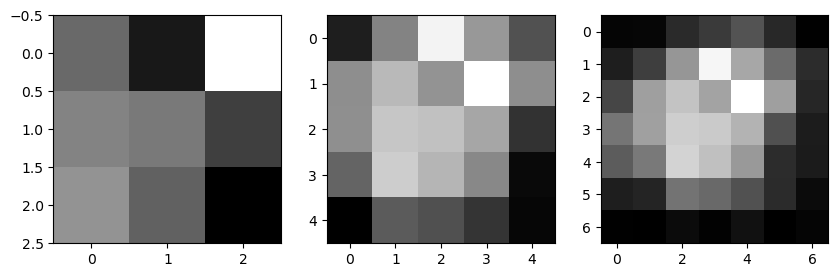

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
valid_conv_flipped = conv(img, k_flipped, mode='valid')
ax[0].imshow(valid_conv_flipped, cmap='gray')

same_conv_flipped = conv(img, k_flipped, mode='same')
ax[1].imshow(same_conv_flipped, cmap='gray')

full_conv_flipped = conv(img, k_flipped, mode='full')
ax[2].imshow(full_conv_flipped, cmap='gray')

## The `correlate` function

Let us now use the `correlate` function.

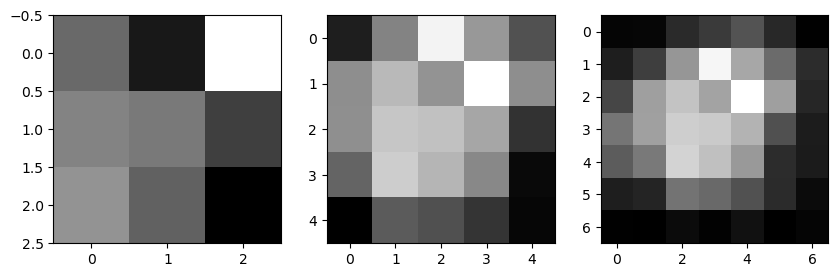

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

valid_corr = corr(img, k, mode='valid')
ax[0].imshow(valid_corr, cmap='gray')

same_corr = corr(img, k, mode='same')
ax[1].imshow(same_corr, cmap='gray')

full_corr = corr(img, k, mode='full')
ax[2].imshow(full_corr, cmap='gray')

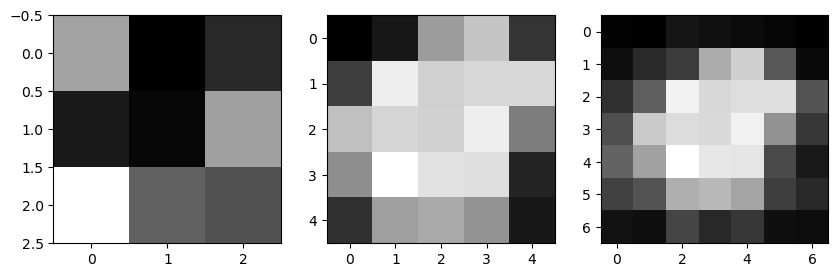

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

valid_corr_flipped = corr(img, k_flipped, mode='valid')
ax[0].imshow(valid_corr_flipped, cmap='gray')

same_corr_flipped = corr(img, k_flipped, mode='same')
ax[1].imshow(same_corr_flipped, cmap='gray')

full_corr_flipped = corr(img, k_flipped, mode='full')
ax[2].imshow(full_corr_flipped, cmap='gray')

In [10]:
valid_conv_flipped[:, :, 0] ,valid_corr[:, :, 0]

(array([[ 88550,  73909, 115413],
        [ 93378,  91296,  80915],
        [ 96016,  86955,  69566]]),
 array([[ 88550,  73909, 115413],
        [ 93378,  91296,  80915],
        [ 96016,  86955,  69566]]))

Now, as `correlate` is the same as `convolution` but with the filter flipped, the following assertions must pass:

In [11]:
assert np.allclose(valid_conv_flipped, valid_corr)
assert np.allclose(same_conv_flipped, same_corr)
assert np.allclose(full_conv_flipped, full_corr)

This is indeed the case.

## Custom Convolution Function

We are defining a function that will perform the convolution operation.

In [12]:
def convolve(image, kernel, stride=1, padding='same'):
    """
    Calculate the convolution of an image with a kernel (This is actually a cross-correlation)

    Parameters
    ----------
    image : numpy.ndarray
        The image to convolve shape (H, W, C)
    kernel : numpy.ndarray
        The kernel to convolve with shape (H, W, C)
    stride : int
        The stride of the convolution, default is 1
    padding : str or int
        The padding of the convolution, default is 'same'
        - If 'same' the padding is calculated to keep the output size the same as the input size
        - If 'valid' no padding is applied
        - If 'full' the padding is calculated to keep the output size the same as the input size + the kernel size - 1
        - If int, a padding of that size is applied
    
    Returns
    -------
    numpy.ndarray
        The convolved image, shape (H, W)
    """
    # Get shapes of image and kernel
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
    if len(kernel.shape) == 2:
        kernel = kernel[:, :, np.newaxis]
    (iH, iW, iC) = image.shape
    (kH, kW, kC) = kernel.shape

    # Check if the kernel and image have the same number of channels
    if iC != kC:
        raise ValueError("The number of channels in the image and kernel must be the same")

    if padding == "same":
        padding = int((kW - 1) / 2)
    elif padding == "valid":
        padding = 0
    elif padding == "full":
        padding = int(kW - 1)

    # Compute the size of the output volume
    oH = int((iH - kH + 2 * padding) / stride) + 1
    oW = int((iW - kW + 2 * padding) / stride) + 1

    # Initialize the output volume
    output = np.zeros((oH, oW))

    # Pad the image
    image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), 'constant')

    # Loop over the output volume
    for y in np.arange(0, oH):
        for x in np.arange(0, oW):
            roi = image[y * stride:y * stride + kH, x * stride:x * stride + kW]

            k = np.sum(roi * kernel)
            output[y, x] = k

    # Return the output volume
    return output

In [13]:
assert np.allclose(same_corr.squeeze(), convolve(img, k, padding='same').squeeze()), "Same padding is not correct"
assert np.allclose(valid_corr.squeeze(), convolve(img, k, padding='valid').squeeze()), "Valid padding is not correct"
assert np.allclose(full_corr.squeeze(), convolve(img, k, padding='full').squeeze()), "Full padding is not correct"

So, for one channel, both are giving the same result. What about when we have multiple channels?

In [14]:
img2 = np.random.randint(0, 255, (5, 5, 3))
k2 = np.random.randint(0, 255, (3, 3, 3))

valid_corr_multi = np.sum(corr(img2, k2, mode='valid'), axis=-1)
valid_corr_multi_function = convolve(img2, k2, padding='valid')
try:
    assert np.allclose(valid_corr_multi, valid_corr_multi_function)
except AssertionError:
    print("Valid padding is not correct")

same_corr_multi = np.sum(corr(img2, k2, mode='same'), axis=-1)
same_corr_multi_function = convolve(img2, k2, padding='same')
try:
    assert np.allclose(same_corr_multi, same_corr_multi_function)
except AssertionError:
    print("Same padding is not correct")

full_corr_multi = np.sum(corr(img2, k2, mode='full'), axis=-1)
full_corr_multi_function = convolve(img2, k2, padding='full')
try:
    assert np.allclose(full_corr_multi, full_corr_multi_function)
except AssertionError:
    print("Full padding is not correct")

Same padding is not correct
Full padding is not correct


In [15]:
same_corr_multi_function.shape == img2[:, :, 1].shape

True

So, it seems that only the `same` padding is giving the same result. Assuming that the function written by us is correct, if we want to use multiple channels, we need to use our function.

## Checking Which Function is correct

To check which function is correct, we'll use the following image:

In [16]:
image = np.array(
    [
        [
            [1, 2, 3, 3],
            [4, 5, 6, 3],
            [7, 8, 9, 3],
            [7, 8, 9, 3],
        ],
        [
            [9, 8, 7, 2],
            [4, 5, 6, 2],
            [3, 2, 1, 2],
            [3, 2, 1, 2],
        ],
        [
            [7, 6, 5, 1],
            [8, 9, 4, 1],
            [1, 2, 3, 1],
            [1, 2, 3, 1],
        ],
    ]
).T
image.shape, image

((4, 4, 3),
 array([[[1, 9, 7],
         [4, 4, 8],
         [7, 3, 1],
         [7, 3, 1]],
 
        [[2, 8, 6],
         [5, 5, 9],
         [8, 2, 2],
         [8, 2, 2]],
 
        [[3, 7, 5],
         [6, 6, 4],
         [9, 1, 3],
         [9, 1, 3]],
 
        [[3, 2, 1],
         [3, 2, 1],
         [3, 2, 1],
         [3, 2, 1]]]))

In [17]:
kernel = np.array(
    [
        [
            [-1, 0, 0],
            [0, -1, 0],
            [0, 0, -1],
        ],
        [
            [0, 0, 0],
            [-1, -1, -1],
            [0, 0, 0],
        ],
        [
            [-1, 0, 0],
            [-1, 0, 0],
            [-1, 0, 0],
        ],
    ]
).T
kernel.shape, kernel

((3, 3, 3),
 array([[[-1,  0, -1],
         [ 0, -1, -1],
         [ 0,  0, -1]],
 
        [[ 0,  0,  0],
         [-1, -1,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0, -1,  0],
         [-1,  0,  0]]]))

In [18]:
image.T, kernel.T

(array([[[1, 2, 3, 3],
         [4, 5, 6, 3],
         [7, 8, 9, 3],
         [7, 8, 9, 3]],
 
        [[9, 8, 7, 2],
         [4, 5, 6, 2],
         [3, 2, 1, 2],
         [3, 2, 1, 2]],
 
        [[7, 6, 5, 1],
         [8, 9, 4, 1],
         [1, 2, 3, 1],
         [1, 2, 3, 1]]]),
 array([[[-1,  0,  0],
         [ 0, -1,  0],
         [ 0,  0, -1]],
 
        [[ 0,  0,  0],
         [-1, -1, -1],
         [ 0,  0,  0]],
 
        [[-1,  0,  0],
         [-1,  0,  0],
         [-1,  0,  0]]]))

In [19]:
valid_func = convolve(image, kernel, padding="valid").astype(int)
valid_corr = np.sum(corr(image, kernel, mode = "valid"), axis=-1).astype(int)
try:
    assert np.allclose(valid_corr, valid_func)
except AssertionError:
    print("Values do not match")
valid_func.T, valid_corr.T

(array([[-46, -41],
        [-37, -35]]),
 array([[-46, -41],
        [-37, -35]]))

For `same` padding, calculating the convolution by hand, we get:

$$
\begin{bmatrix}
-23&-47&-38&-21\\
-21&-46&-41&-26\\
-20&-37&-35&-22\\
-212&-23&-26&-21\\
\end{bmatrix}
$$

In [20]:
same_correct = np.array(
    [
        [-23, -47, -38, -21],
        [-21, -46, -41, -26],
        [-20, -37, -35, -22],
        [-12, -23, -26, -21],
    ]
).T

same_correct

array([[-23, -21, -20, -12],
       [-47, -46, -37, -23],
       [-38, -41, -35, -26],
       [-21, -26, -22, -21]])

In [21]:
same_func = convolve(image, kernel, padding="same").astype(int)
same_corr = np.sum(corr(image, kernel, mode = "same"), axis=-1).astype(int)
if np.allclose(same_corr, same_correct):
    print("SciPy valued are correct")
elif np.allclose(same_func, same_correct):
    print("Your function values are correct")
else:
    print("Values do not match")

Your function values are correct


This shows that our implementation is correct.

## Modifying the `correlate` function

Though our function is correct, it works very slow, as you'll see in the final section. Here, we'll define a function which uses `correlate` to implement the convolution operation.

The idea is that the `correlate` function is used to calculate the convolution for each channel and then the results are summed up.

In [22]:
def convolution_scipy(image, kernel, padding, stride=1):
    # Get shapes of image and kernel
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
    if len(kernel.shape) == 2:
        kernel = kernel[:, :, np.newaxis]
    (iH, iW, iC) = image.shape
    (kH, kW, kC) = kernel.shape

    # Check if the kernel and image have the same number of channels
    if iC != kC:
        raise ValueError("The number of channels in the image and kernel must be the same")

    if padding == "same":
        padding = int((kW - 1) / 2)
    elif padding == "valid":
        padding = 0
    elif padding == "full":
        padding = int(kW - 1)

    # Compute the size of the output volume
    oH = int((iH - kH + 2 * padding) / stride) + 1
    oW = int((iW - kW + 2 * padding) / stride) + 1

    # Initialize the output volume
    output = np.zeros((oH, oW))

    # Pad the image
    image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), 'constant')

    # Loop over the color channel and use scipy correlate
    for c in range(iC):
        output += corr(image[:, :, c], kernel[:, :, c], mode="valid")
    
    # Return the output volume
    return output

Let's see if your function works with the same values as the scipy function.

In [23]:
same_func = convolution_scipy(image, kernel, padding="same").astype(int)
same_corr = np.sum(corr(image, kernel, mode = "same"), axis=-1).astype(int)
if np.allclose(same_corr, same_correct):
    print("SciPy valued are correct")
elif np.allclose(same_func, same_correct):
    print("Your function values are correct")
else:
    print("Values do not match")

Your function values are correct


Great! Let's run some more checks.

In [24]:
img2 = np.random.randint(0, 255, (5, 5, 3))
k2 = np.random.randint(0, 255, (3, 3, 3))

valid_corr_original_func = convolve(img2, k2, padding='valid')
valid_corr_modified_func = convolution_scipy(img2, k2, padding='valid')

try:
    assert np.allclose(valid_corr_original_func, valid_corr_modified_func)
    print("Valid padding is correct")
except AssertionError:
    print("Valid padding is not correct")

same_corr_original_func = convolve(img2, k2, padding='same')
same_corr_modified_func = convolution_scipy(img2, k2, padding='same')

try:
    assert np.allclose(same_corr_original_func, same_corr_modified_func)
    print("Same padding is correct")
except AssertionError:
    print("Same padding is not correct")

full_corr_original_func = convolve(img2, k2, padding='full')
full_corr_modified_func = convolution_scipy(img2, k2, padding='full')

try:
    assert np.allclose(full_corr_original_func, full_corr_modified_func)
    print("Full padding is correct")
except AssertionError:
    print("Full padding is not correct")

Valid padding is correct
Same padding is correct
Full padding is correct


Excellent!

# Comparing Speed

For this, we'll create larger arrays and compare the speed of these methods.

## Creating Larger Arrays

In [25]:
image = np.random.randint(0, 255, (512, 512, 3))
kernel = np.random.randint(0, 255, (5, 5, 3))

## The Original Function

In [26]:
%timeit convolve(image, kernel, padding='same')
%timeit convolve(image, kernel, padding='valid')
%timeit convolve(image, kernel, padding='full')

2.28 s ± 465 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.98 s ± 50 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.07 s ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## The Modified Function

In [27]:
%timeit convolution_scipy(image, kernel, padding='same')
%timeit convolution_scipy(image, kernel, padding='valid')
%timeit convolution_scipy(image, kernel, padding='full')

94.5 ms ± 6.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
90.3 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
80 ms ± 6.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Scipy `correlate` Function

In [28]:
%timeit corr(image, kernel, mode='same')
%timeit corr(image, kernel, mode='valid')
%timeit corr(image, kernel, mode='full')

138 ms ± 4.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
108 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
127 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
2280/94.5, 1980/90.3, 2070/80

(24.126984126984127, 21.926910299003325, 25.875)

So, using the modyfied `correlate` function is over 20 times faster than using the original function written by us.

# Some More Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve as conv
from scipy.signal import correlate as corr
from nn.convolution import Convolution

In [2]:
def convolve(image, kernel, stride=1, padding='same'):
    """
    Calculate the convolution of an image with a kernel (This is actually a cross-correlation)

    Parameters
    ----------
    image : numpy.ndarray
        The image to convolve shape (H, W, C)
    kernel : numpy.ndarray
        The kernel to convolve with shape (H, W, C)
    stride : int
        The stride of the convolution, default is 1
    padding : str or int
        The padding of the convolution, default is 'same'
        - If 'same' the padding is calculated to keep the output size the same as the input size
        - If 'valid' no padding is applied
        - If 'full' the padding is calculated to keep the output size the same as the input size + the kernel size - 1
        - If int, a padding of that size is applied
    
    Returns
    -------
    numpy.ndarray
        The convolved image, shape (H, W)
    """
    # Get shapes of image and kernel
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
    if len(kernel.shape) == 2:
        kernel = kernel[:, :, np.newaxis]
    (iH, iW, iC) = image.shape
    (kH, kW, kC) = kernel.shape

    # Check if the kernel and image have the same number of channels
    if iC != kC:
        raise ValueError("The number of channels in the image and kernel must be the same")

    if padding == "same":
        padding = int((kW - 1) / 2)
    elif padding == "valid":
        padding = 0
    elif padding == "full":
        padding = int(kW - 1)

    # Compute the size of the output volume
    oH = int((iH - kH + 2 * padding) / stride) + 1
    oW = int((iW - kW + 2 * padding) / stride) + 1

    # Initialize the output volume
    output = np.zeros((oH, oW))

    # Pad the image
    image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), 'constant')

    # Loop over the output volume
    for y in np.arange(0, oH):
        for x in np.arange(0, oW):
            roi = image[y * stride:y * stride + kH, x * stride:x * stride + kW]

            k = np.sum(roi * kernel)
            output[y, x] = k

    # Return the output volume
    return output

In [3]:
def convolution_scipy(image, kernel, padding):
    # Get shapes of image and kernel
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
    if len(kernel.shape) == 2:
        kernel = kernel[:, :, np.newaxis]
    (iH, iW, iC) = image.shape
    (kH, kW, kC) = kernel.shape

    # Check if the kernel and image have the same number of channels
    if iC != kC:
        raise ValueError("The number of channels in the image and kernel must be the same")

    if padding == "same":
        padding = int((kW - 1) / 2)
    elif padding == "valid":
        padding = 0
    elif padding == "full":
        padding = int(kW - 1)

    # Compute the size of the output volume
    oH = int((iH - kH + 2 * padding)) + 1
    oW = int((iW - kW + 2 * padding)) + 1

    # Initialize the output volume
    output = np.zeros((oH, oW))

    # Pad the image
    image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), 'constant')

    # Loop over the color channel and use scipy correlate
    for c in range(iC):
        output += corr(image[:, :, c], kernel[:, :, c], mode="valid")
    
    # Return the output volume
    return output

In [4]:
con = Convolution()

In [5]:
hi, wi, ci = 128, 128, 1
hk, wk, co = 5,5, 10
stride = 1
padding = "same"

image = np.random.randint(0, 255, (hi, wi, ci))
kernels = np.random.randint(0, 255, (hk, wk, ci, co))
biases = np.random.randint(0, 255, (co,))
from_class = con.convolve(image, kernels, stride=stride, padding=padding, bias=biases)
print(from_class.shape)

if isinstance(padding, int):
    padding = padding
elif padding == "same":
    padding = int((hk - 1) / 2)
elif padding == "valid":
    padding = 0
elif padding == "full":
    padding = int(hk - 1)
    
ho = int((hi - hk + 2 * padding)/stride) + 1
wo = int((wi - wk + 2 * padding)/stride) + 1
output_slow = np.zeros((ho, wo, co))

for i in range(co):
    output_slow[:, :, i] = convolve(image, kernels[:, :, :, i], padding=padding, stride=stride) + biases[i]

output_slow.shape

(128, 128, 10)


(128, 128, 10)

In [6]:
ho_2 = int((hi - hk + 2 * padding)) + 1
wo_2 = int((wi - wk + 2 * padding)) + 1
output_fast = np.zeros((ho_2, wo_2, co))

for i in range(co):
    output_fast[:, :, i] = convolution_scipy(image, kernels[:, :, :, i], padding=padding) + biases[i]

output_fast = output_fast[::stride, ::stride, :]
output_fast.shape

(128, 128, 10)

In [7]:
np.allclose(output_slow, output_fast), np.allclose(output_slow, from_class)

(True, True)

## Max Pooling

In [17]:
hi, wi, ci = 4, 4, 3
hk, wk, co = 2,2, 10
stride = 2
padding = "same"
image = np.random.randint(0, 255, (hi, wi, ci))
ho = int((hi - hk) / stride) + 1
wo = int((wi - wk) / stride) + 1
output = np.zeros((ho, wo))

for x in range(wo):
        for y in range(ho):
            roi = image[
                y * stride : y * stride + hk,
                x * stride : x * stride + wk,
            ]
            output[y, x] = np.max(roi)
            # print(np.where(roi == np.max(roi)))

In [18]:
output.shape

(2, 2)

In [19]:
output

array([[222., 245.],
       [243., 253.]])

In [20]:
image.T

array([[[217,  11,  84, 216],
        [123, 222, 243,   9],
        [ 63,  28, 222, 129],
        [ 98, 110, 129, 227]],

       [[167,  29, 155, 116],
        [129, 124, 204,  60],
        [208, 245, 226,  20],
        [127, 157,  99,  52]],

       [[  5, 156, 140,   0],
        [ 66,  27, 236, 184],
        [ 42, 129, 253,  64],
        [212, 153,  94,  84]]])

In [21]:
con.max_pool(image,2,2)

array([[222., 245.],
       [243., 253.]])

In [23]:
con.average_pool(image,2,2)

AttributeError: module 'numpy' has no attribute 'avg'